# Training the DriverCo Drowsiness Detection Model
This notebook walks through the process of fine-tuning YOLOv8 on a custom dataset to detect signs of driver fatigue via eye and mouth cues.

## Install YOLOv8
### Why YOLOv8?
We chose YOLOv8 for its speed, accuracy, and ease of use in object detection tasks. It's well-suited for real-time applications like ours.

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.3 MB/s eta 0:00:0000:0100:01


In [12]:
from ultralytics import YOLO
from IPython.display import display , Image
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.125 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6277.7/8062.4 GB disk)


## Train YOLOv8 On Our Custom Dataset

### Visualizing Training Data
Let's take a look at a few sample images from our dataset to verify structure and class clarity.

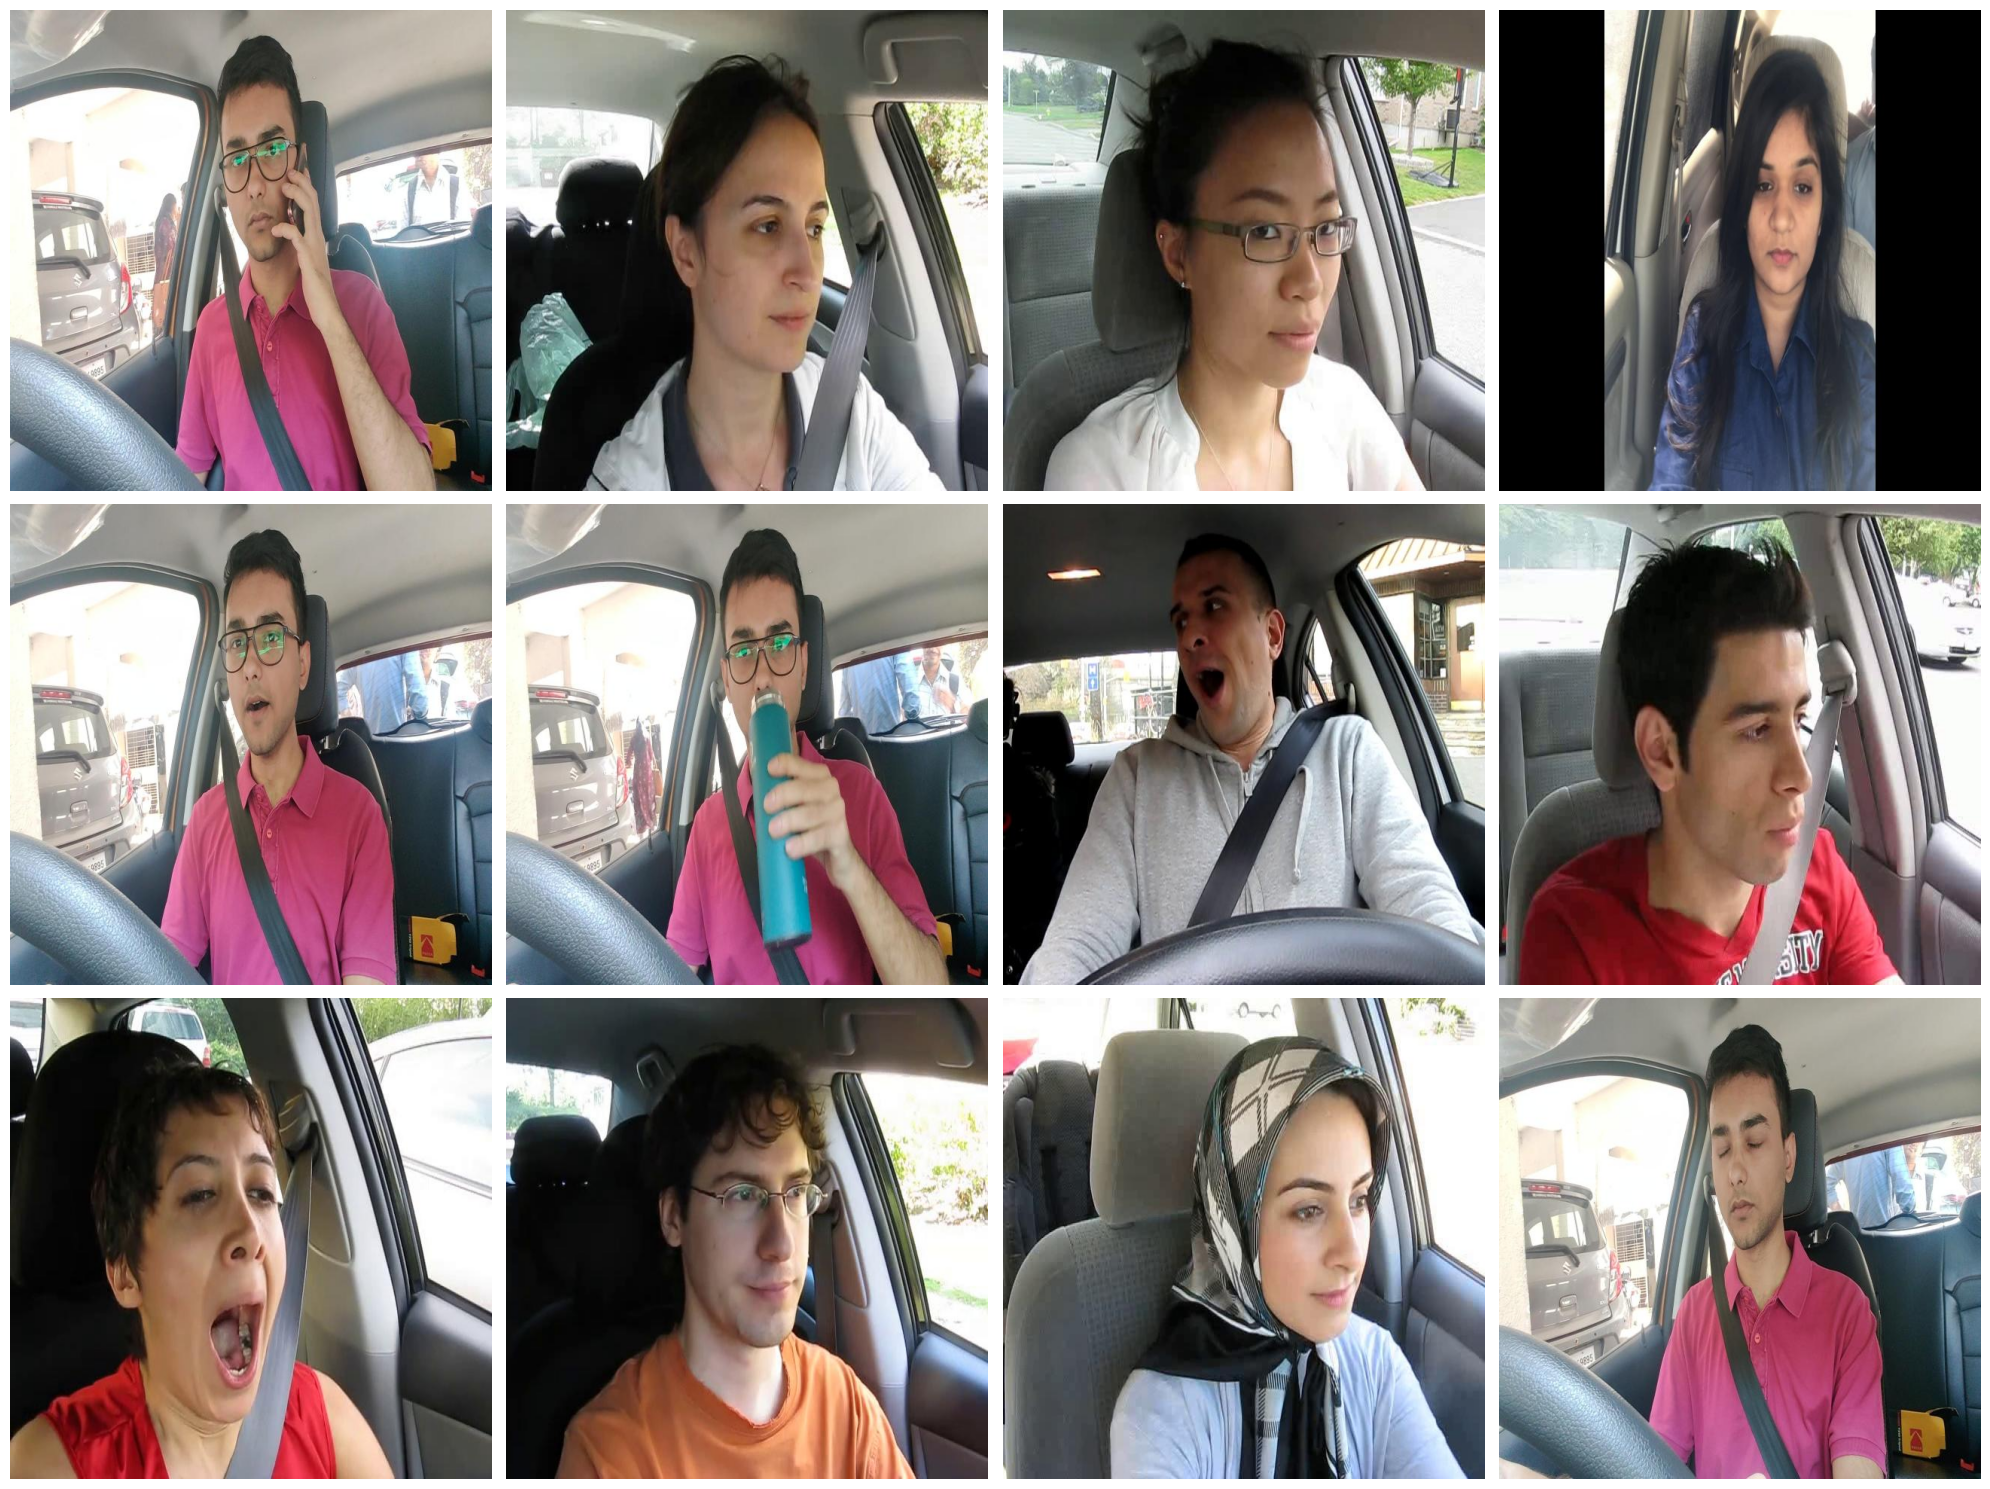

In [2]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

# Get a list of image paths
image_paths = glob.glob('/kaggle/input/drowsiness-detection-v2-augmented-v1/train/images/*.jpg')[24:36]

# Create a figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Iterate over the image paths and display images in subplots
for i, image_path in enumerate(image_paths):
    # Calculate the row and column indices of the current subplot
    row = i // 4
    col = i % 4

    # Open the image using PIL
    img = Image.open(image_path)

    # Display the image in the current subplot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Our dataset follows the YOLO format with an `images/` and `labels/` folder. Each label file contains lines of the form:
   > `<class_id> <x_center> <y_center> <width> <height>`, all normalized between 0 and 1.

In [3]:
import yaml

# Read the contents of the data.yaml file
with open('/kaggle/input/drowsiness-detection-v2-augmented-v1/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

# Update the paths in the test, train, and val sections
data['test'] = '/kaggle/input/drowsiness-detection-v2-augmented-v1/test/images'
data['train'] = '/kaggle/input/drowsiness-detection-v2-augmented-v1/train/images'
data['val'] = '/kaggle/input/drowsiness-detection-v2-augmented-v1/val/images'

# Write the modified data back to the data.yaml file
with open('/kaggle/working/data.yaml', 'w') as file:
    yaml.dump(data, file)

### Training YOLOv8 on Custom Drowsiness Dataset
We're training for 50 epochs on a labeled dataset that includes eye and mouth states. The goal is to detect visual signs of drowsiness.

In [17]:
!yolo task=detect mode=train model=yolov8m.pt data=data.yaml epochs=50 imgsz=640 plots=True

Ultralytics 8.3.125 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscri

### Training Results and Validation
Here’s the performance chart showing loss, precision, recall, and mAP over training epochs.

In [18]:
from IPython.display import display , Image
from IPython import display
display.clear_output()

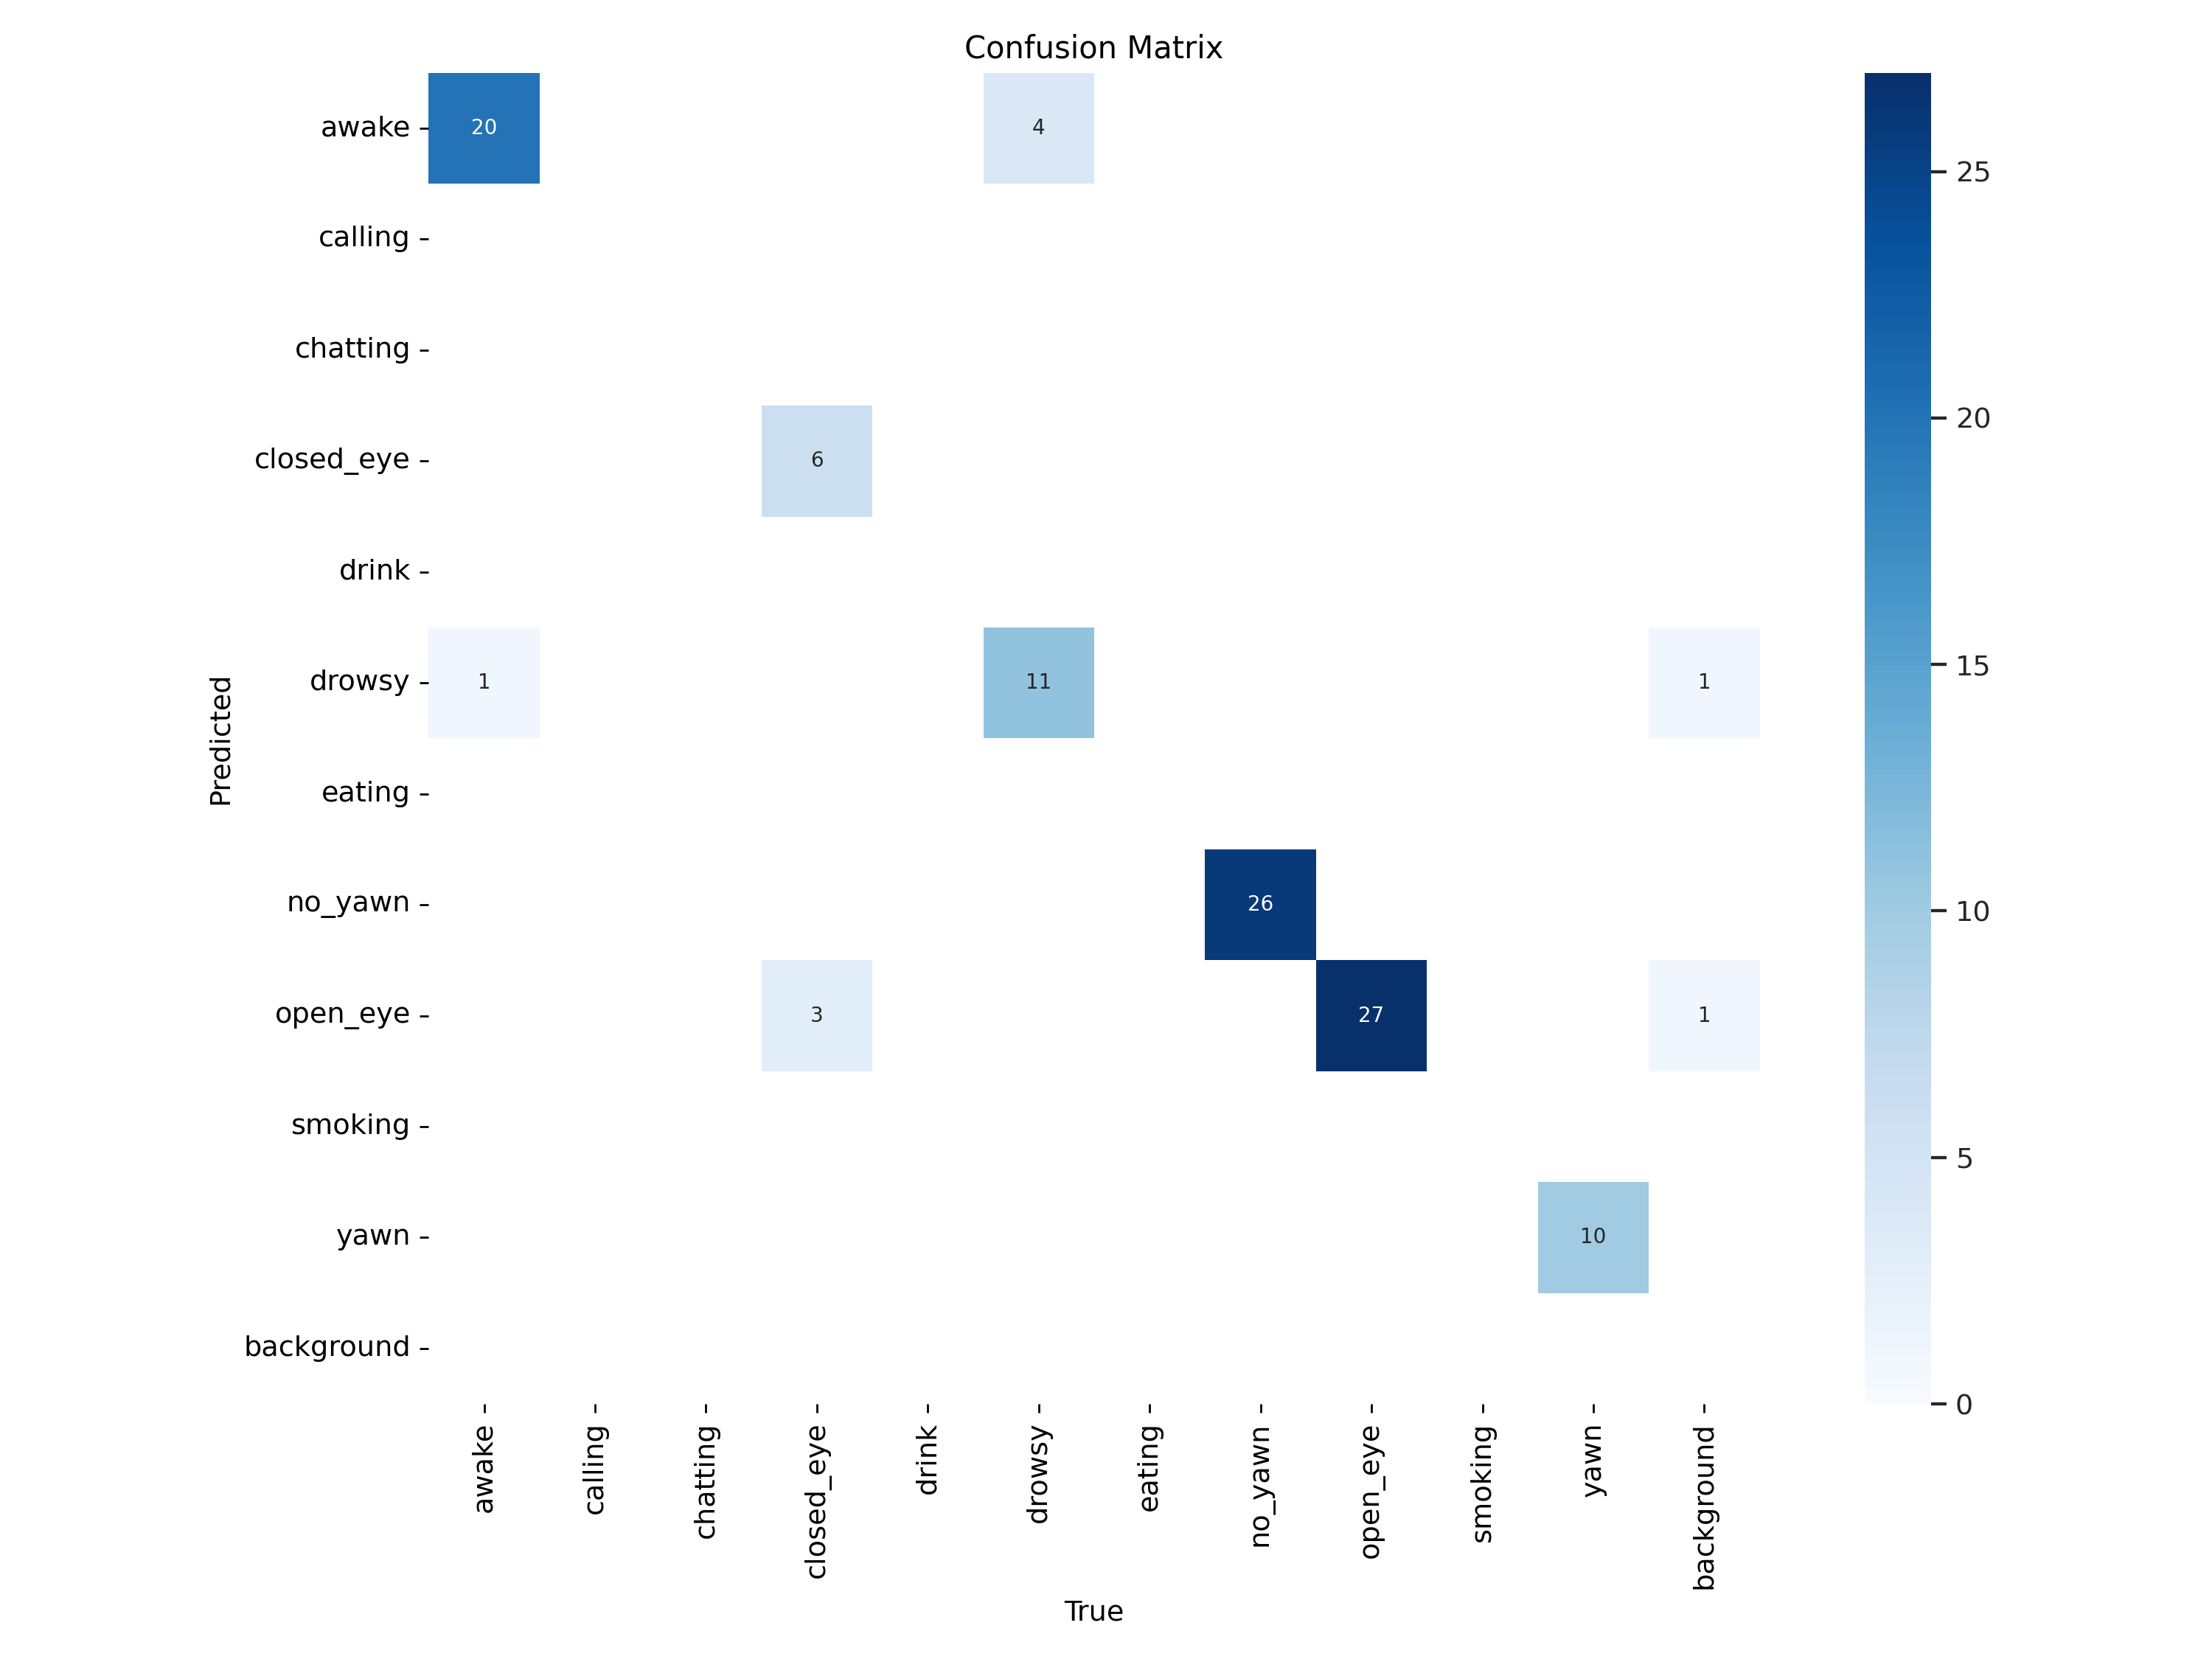

In [20]:
Image(filename = f'/kaggle/working/runs/detect/train2/confusion_matrix.png' , height = 600)

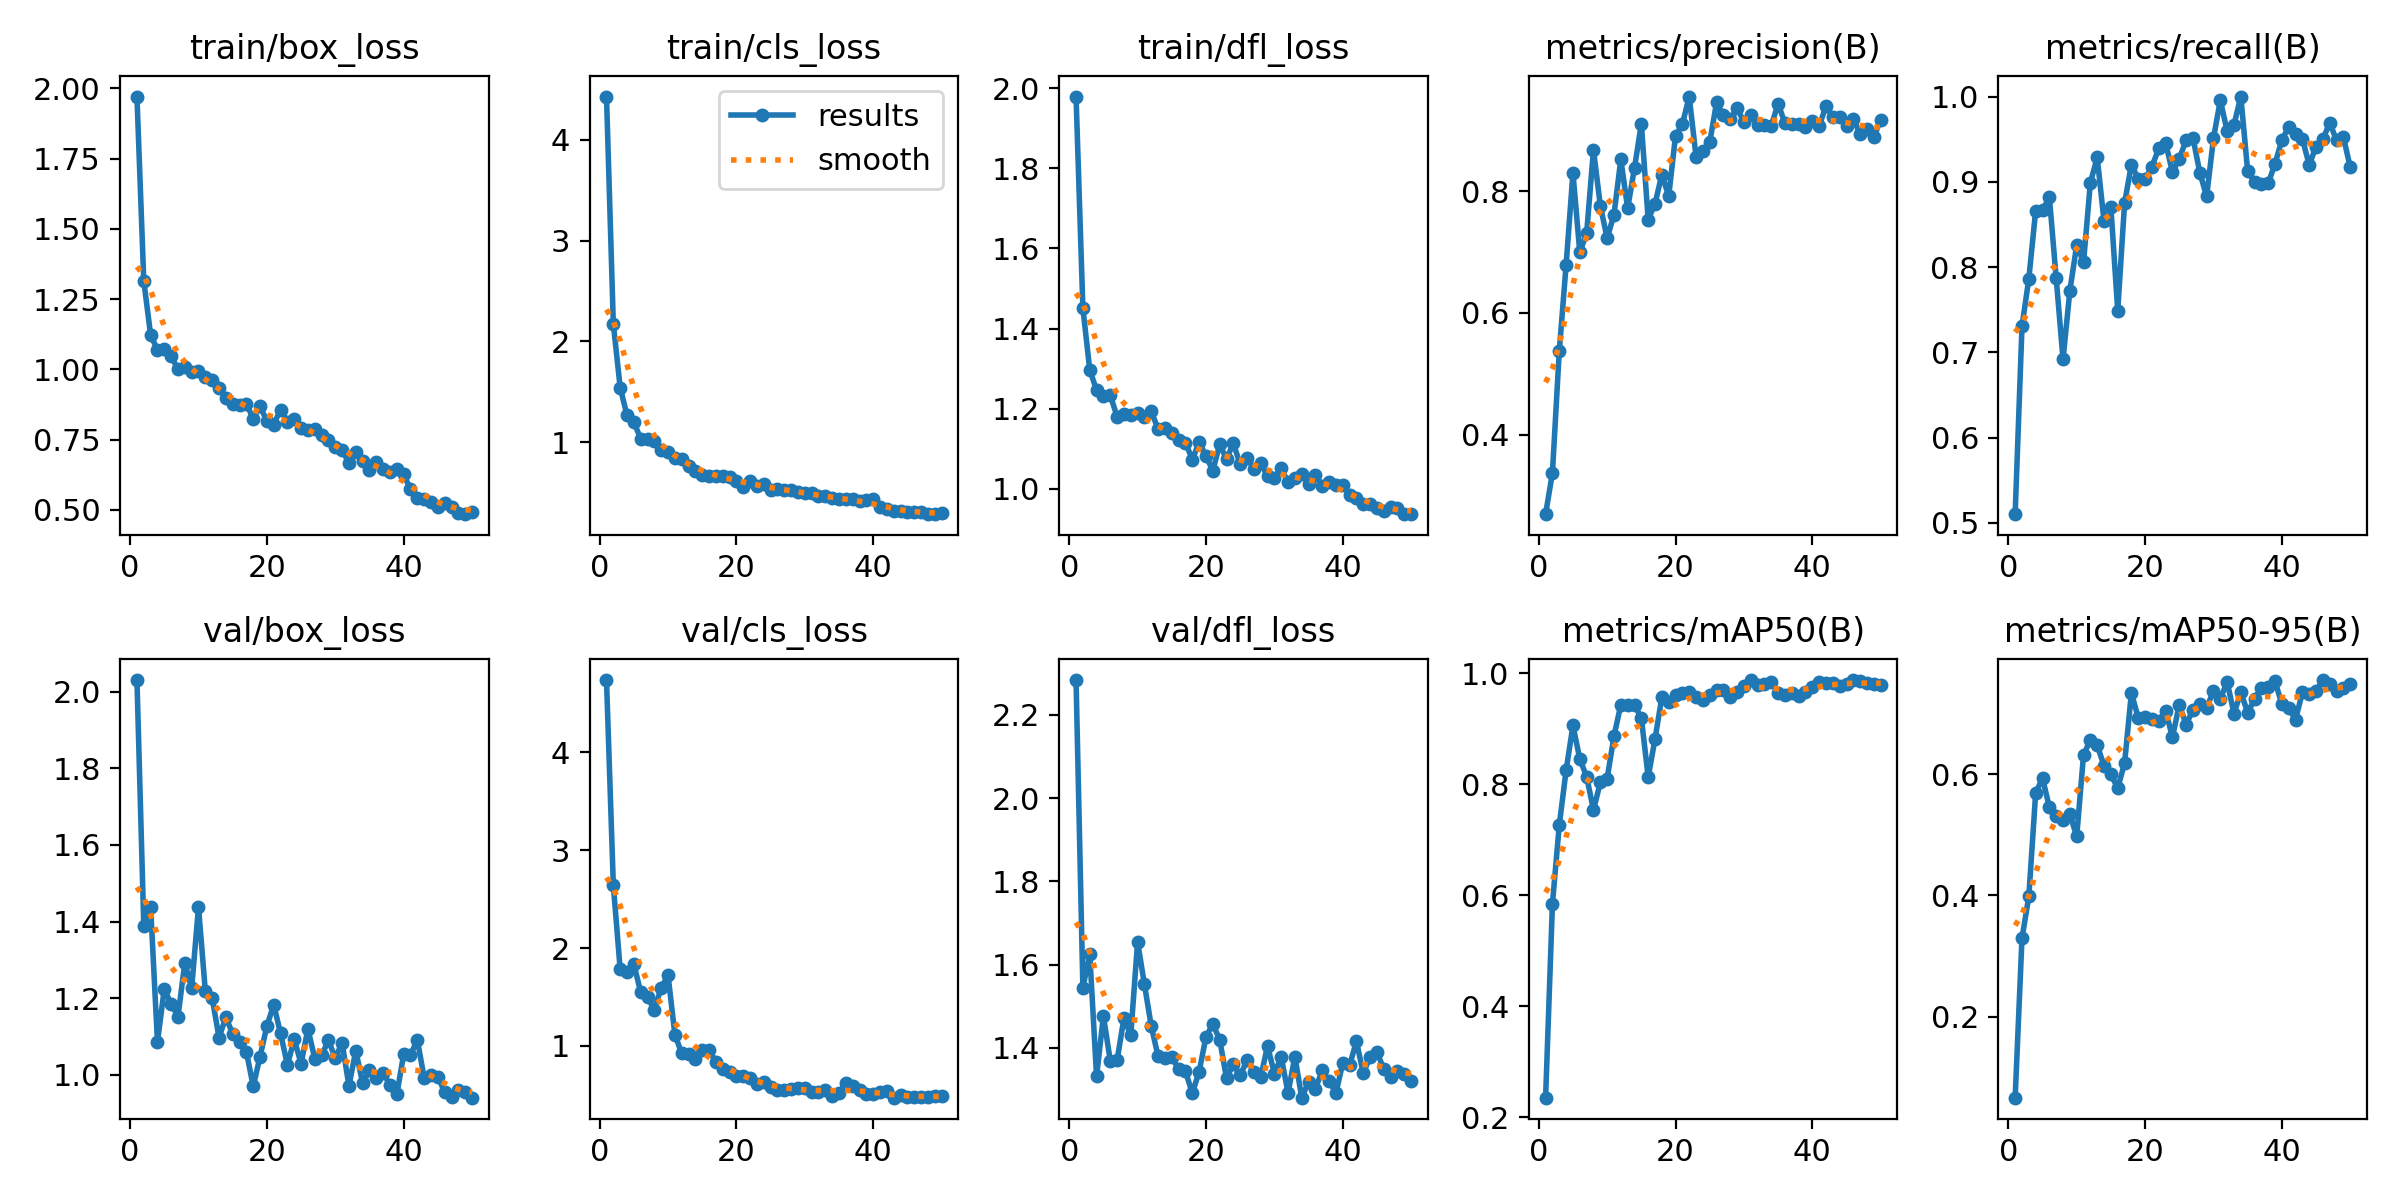

In [21]:
Image(filename=f'/kaggle/working/runs/detect/train2/results.png', width=600)

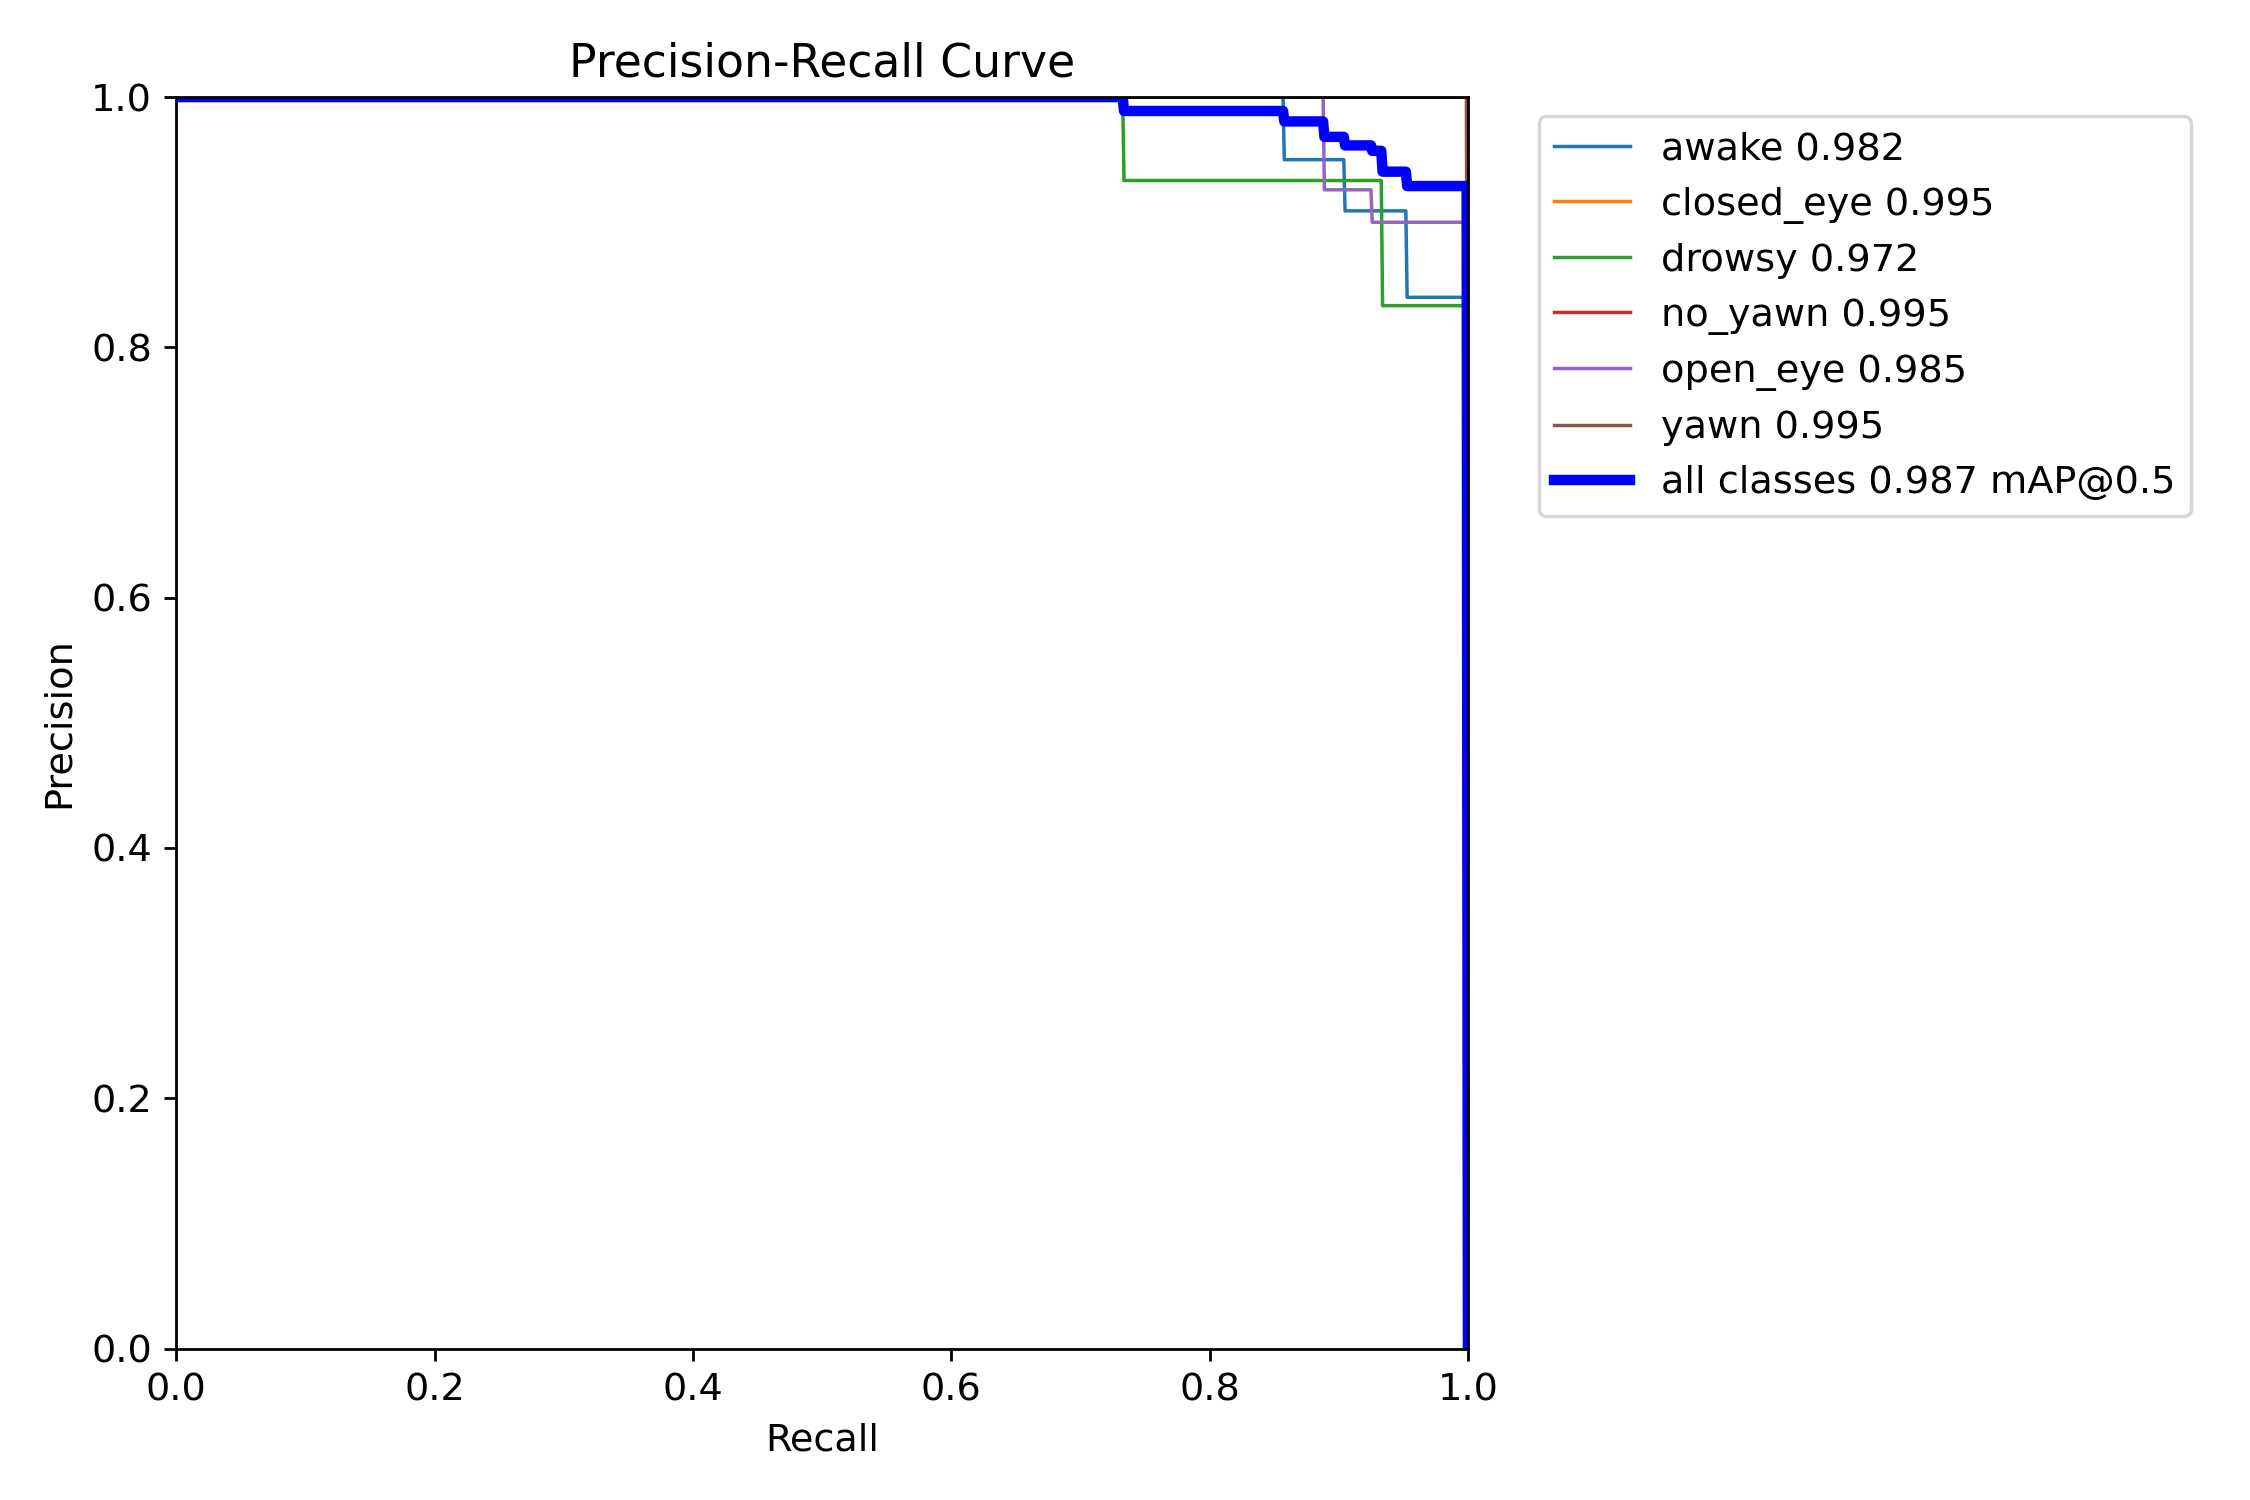

In [22]:
Image(filename=f'/kaggle/working/runs/detect/train2/PR_curve.png', width=600)

In [24]:
!yolo task=detect mode=val model=/kaggle/working/runs/detect/train2/weights/best.pt data=data.yaml  # we just specify the weights that we want to validation off / passing all images through our model for validation

Ultralytics 8.3.125 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,846,129 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 81.8±19.8 MB/s, size: 37.1 KB)
val: Scanning /kaggle/input/drowsiness-detection-v2-augmented-v1/Drive Drowsines
WARNING ⚠️ val: Cache directory /kaggle/input/drowsiness-detection-v2-augmented-v1/Drive Drowsiness Detection.v3i.yolov8/valid is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         36        108      0.919      0.949      0.987      0.755
                 awake         21         21      0.835          1      0.982      0.881
            closed_eye          9          9          1       0.77      0.995      0.554
                drowsy         15         15      0.933      0.927      0.972      0.926
               no_yawn         26         26      0.969          1      0.995   

In [29]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train2/weights/best.pt conf=0.5 source="/kaggle/input/drowsiness-detection-v2-augmented-v1/Drive Drowsiness Detection.v3i.yolov8/test/images" save_txt=true save_conf=true

Ultralytics 8.3.125 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,846,129 parameters, 0 gradients, 78.7 GFLOPs

image 1/36 /kaggle/input/drowsiness-detection-v2-augmented-v1/Drive Drowsiness Detection.v3i.yolov8/test/images/10_jpg.rf.e4696bc5b792a8821fb5a9eb8d6c81d6.jpg: 640x640 1 drowsy, 1 open_eye, 1 yawn, 37.3ms
image 2/36 /kaggle/input/drowsiness-detection-v2-augmented-v1/Drive Drowsiness Detection.v3i.yolov8/test/images/132_jpg.rf.15715a998a908288272e174739b0408b.jpg: 640x640 1 drowsy, 1 open_eye, 1 yawn, 37.2ms
image 3/36 /kaggle/input/drowsiness-detection-v2-augmented-v1/Drive Drowsiness Detection.v3i.yolov8/test/images/139_jpg.rf.3cffeb3e581e086f7f1b6658d35b86e7.jpg: 640x640 1 drowsy, 1 open_eye, 1 yawn, 37.1ms
image 4/36 /kaggle/input/drowsiness-detection-v2-augmented-v1/Drive Drowsiness Detection.v3i.yolov8/test/images/13_jpg.rf.e83ea0fa9f9d90ac13b063c899371095.jpg: 640x640 1 drowsy, 1 open_eye, 1 yawn, 37.1ms
image 5/36 /kaggle